# Données

In [1]:
import os
import requests
from scipy.io import loadmat
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np

def get_mnist(): 
    mnist = fetch_openml('mnist_784')
    X = mnist['data']
    X = (mnist['data'] > 128).astype(int)
    y = mnist['target']
    y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()
    return X, y
    
def get_alphadigs():
    if os.path.exists('data/alphadigs.mat'):
        return loadmat('data/alphadigs.mat')
    
    alphadigs_url = 'https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat'
    r = requests.get(alphadigs_url, allow_redirects=True)

    with open('data/alphadigs.mat', 'wb') as f:
        f.write(r.content)
                
    return loadmat('data/alphadigs.mat')

def lire_alpha_digit(digits_list):
    # Charger les données
    dataset = get_alphadigs()

    # Filtrages des données selon la liste de chiffres voulus
    digit2idx = {}
    for i, digit in enumerate(dataset['classlabels'][0]):
        digit2idx[digit[0]] = i
    
    idxs = []
    for digit in digits_list:
        idxs.append(digit2idx[digit])
    
    # Adaptation au format (n, p), chaque colonne designe un pixel et chaque ligne une image
    return np.stack(np.concatenate(dataset['dat'][idxs])).reshape(-1, 20*16)

In [2]:
f = lire_alpha_digit(['0', '2', 'P','F', 'Z'])

In [3]:
f.shape

(195, 320)

In [4]:
import numpy as np
import numpy as np
import random
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(x, 0)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Fonctions élémentaires

## Construction d’un RBM et test sur Binary AlphaDigits

In [5]:
class RBM:
    def __init__(self, p, q):
        self.W = 0.01 * np.random.rand(p,q)
        self.a = np.zeros((1,p))
        self.b = np.zeros((1,q))
        
def init_RBM(p, q):
    return RBM(p, q)

def entree_sortie_RBM(rbm, x):
    return sigmoid(np.dot(x, rbm.W) + rbm.b)

def sortie_entree_RBM(rbm, y): #(n * q) -> (n * p)
    return sigmoid(np.dot(y, rbm.W.T) + rbm.a)

In [6]:
def train_RBM(rbm,X,learning_rate, epochs, batch_size):
        
    n = X.shape[0]
    p = X.shape[1]
    q = len(rbm.b) 
    
    error = []
    for epoch in range(epochs):
        X_copy = X.copy()
    
        for batch  in range(0, n, batch_size):
            X_batch = X_copy[batch:batch + batch_size]
            
            tb = len(X_batch)
            
            v_0 = X_batch # (tb * p)
            #print(tb,p,v_0.shape)
            
            p_h_v_0 = entree_sortie_RBM(rbm,v_0) # (tb * q)
            #print(tb,q,p_h_v_0.shape)
            
            h_0 = (p_h_v_0 > np.random.rand(tb, q)).astype(int) # (tb * q)
            #print(tb,q,h_0.shape)
            
            p_v_h_0 = sortie_entree_RBM(rbm,h_0) # (tb * p)
            #print(tb,p,p_v_h_0.shape)
            v_1 = (p_v_h_0 > np.random.rand(tb, p)).astype(int) # (tb * p)
            #print(tb,p,v_1.shape)
            
            p_h_v_1 = entree_sortie_RBM(rbm,v_1) # (tb * q)
            #print(tb,q,p_h_v_1.shape)
            
            norm_learning_rate = learning_rate/tb
            
            rbm.W += norm_learning_rate * (np.dot(v_0.T, p_h_v_0) - np.dot(v_1.T, p_h_v_1)) # (p * q)   
            #print(p,q,rbm.W.shape)     
            rbm.a += norm_learning_rate * np.sum(v_0 - v_1, axis=0) # (1 * p)
            #print(p,rbm.a.shape)
            rbm.b += norm_learning_rate * np.sum(p_h_v_0 - p_h_v_1, axis=0) # (1 * q)
            #print(q,rbm.b.shape)
            
        H = entree_sortie_RBM(rbm,X)
        X_reconstruit = sortie_entree_RBM(rbm,H)
        loss = np.sum((X - X_reconstruit)**2)/(n*p)
        error.append(loss)
        if epoch % 10 == 0:
            print("Epoch : ", epoch, "Erreur : ", loss)
            
    return rbm,error


In [7]:
def generer_image_RBM(rbm, nb_iter, nb_images):
    p = rbm.a.shape[1]
    q = len(rbm.b)
    for i in range(nb_images):
        image = np.random.uniform(0, 1, (1, p))
        for j in range(nb_iter):
            prob_h_given_v = entree_sortie_RBM(rbm, image)
            h = (prob_h_given_v > np.random.rand(q)) * 1.0
            prob_v_given_h = sortie_entree_RBM(rbm, h)
            image = (prob_v_given_h > np.random.rand(p)) * 1.0

        image = np.reshape(image, (20, 16))
        plt.imshow(image, cmap='gray')
        plt.show()

Epoch :  0 Erreur :  0.18457764686016961
Epoch :  10 Erreur :  0.09443564243197135
Epoch :  20 Erreur :  0.04979250348592288
Epoch :  30 Erreur :  0.0293454511808028
Epoch :  40 Erreur :  0.018416763783077304
Epoch :  50 Erreur :  0.012160628262170509
Epoch :  60 Erreur :  0.008636554022741149
Epoch :  70 Erreur :  0.006429656143627346
Epoch :  80 Erreur :  0.004685376671192025
Epoch :  90 Erreur :  0.003806135750465557


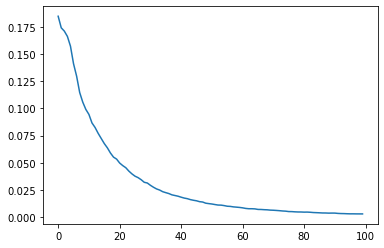

In [8]:
X = lire_alpha_digit(['X'])
p = len(X[0])
q = 100
Rbm = init_RBM(p,q)
Rbm,error = train_RBM(Rbm,X,0.1, 100, 3)
plt.plot(error)

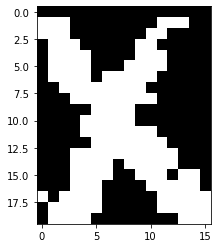

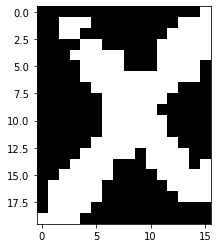

In [9]:
generer_image_RBM(Rbm, 500, 2)

# Construction d’un DBN et test sur Binary AlphaDigits

In [10]:
def init_DBN(config):
    for i in range(len(config)-1):
        if i == 0:
            DBN = [init_RBM(config[i], config[i+1])]
        else:
            DBN.append(init_RBM(config[i], config[i+1]))
    return DBN

def train_DBN(DBN, H, epsilon, epochs, batch_size):
    for i in range(len(DBN)):
            DBN[i],error = train_RBM(DBN[i], H, epsilon, epochs, batch_size)
            H = entree_sortie_RBM(DBN[i],H)
    return DBN

In [11]:
def generer_image_DBN(Dbm, nb_iter, nb_images):
    for i in range(nb_images):
        v_0 = np.random.uniform(0, 1, (1, config[0]))
        v_k = v_0
        for j in range(nb_iter):
            
            for y in range(0,len(Dbm)): 
                prob_h_given_v = entree_sortie_RBM(Dbm[y], v_k)
                v_k = (prob_h_given_v > np.random.rand(config[y+1])) * 1.0

            h_k = v_k
            for k in range(len(Dbm)-1, -1, -1):
                prob_v_given_h = sortie_entree_RBM(Dbm[k], h_k)
                h_k = (prob_v_given_h > np.random.rand(config[k])) * 1.0

            v_k = h_k

        image = np.reshape(v_k, (20, 16))
        plt.imshow(image, cmap='gray')
        plt.show()

Epoch :  0 Erreur :  0.18820013085501566
Epoch :  10 Erreur :  0.09096221023257697
Epoch :  20 Erreur :  0.048872915634340965
Epoch :  30 Erreur :  0.028986540043328336
Epoch :  40 Erreur :  0.018612683994708605
Epoch :  50 Erreur :  0.012615035681713956
Epoch :  60 Erreur :  0.009420944227700888
Epoch :  70 Erreur :  0.006584994172535079
Epoch :  80 Erreur :  0.005082756030590295
Epoch :  90 Erreur :  0.0041784777376601455
Epoch :  0 Erreur :  0.1731631439113572
Epoch :  10 Erreur :  0.10491227187619706
Epoch :  20 Erreur :  0.05710088967350462
Epoch :  30 Erreur :  0.03386944589209761
Epoch :  40 Erreur :  0.021241088439708008
Epoch :  50 Erreur :  0.015061995490988916
Epoch :  60 Erreur :  0.011660978984858452
Epoch :  70 Erreur :  0.008816817823756802
Epoch :  80 Erreur :  0.006695754581328273
Epoch :  90 Erreur :  0.005665587583491926
Epoch :  0 Erreur :  0.25066378201874323
Epoch :  10 Erreur :  0.1569504610338238
Epoch :  20 Erreur :  0.09008509454570264
Epoch :  30 Erreur :  0.

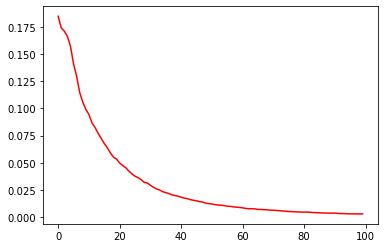

In [12]:
config = [len(X[0]),100,50,100]
X  = lire_alpha_digit(['X'])
Dbm = init_DBN(config)
Dbm = train_DBN(Dbm, X, 0.1, 100, 3)
plt.plot(error, "red")

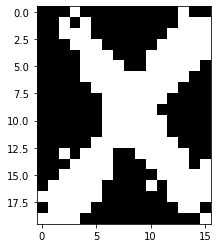

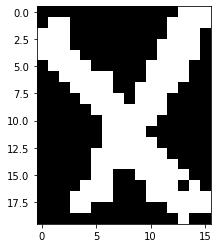

In [13]:
plt.figure()
generer_image_DBN(Dbm, 500, 2)

# Étude sur Binary AlphaDigit

In [14]:
from principal_DBN_alpha import *
# Spécification des paramètres liés au réseau et à l’apprentissage
input_size = 320  # Taille de l'entrée (20 x 16 pixels)
hidden_sizes = [25, 25]  # Nombre de neurones dans chaque couche cachée
output_size = 2  # Nombre de neurones en sortie (10 classes)
num_iters = 100  # Nombre d'itérations pour les descentes de gradient
learning_rate = 0.02  # Taux d'apprentissage
batch_size = 100  # Taille des mini-batch
num_train_data = 50000  # Nombre de données d'apprentissage
num_val_data = 200  # Nombre de données de validation
num_test_data = 200  # Nombre de données de test

# Charger les données
data = lire_alpha_digit(['0', '2', 'F', 'Z'])

# On fait un mélange les données aléatoirement (Shuffle)
random.shuffle(data)

# Filtration des données pour ne garder que les données d'apprentissage
train_data = data[:num_train_data] # sélection des num_train_data premières données de la liste data

Epoch :  0 Erreur :  0.2069604812024641
Epoch :  10 Erreur :  0.08979463614743617
Epoch :  20 Erreur :  0.05141072592771299
Epoch :  30 Erreur :  0.03566399458548302
Epoch :  40 Erreur :  0.02666961672276448
Epoch :  50 Erreur :  0.021045816286478815
Epoch :  60 Erreur :  0.01708253087203517
Epoch :  70 Erreur :  0.013973469952829297
Epoch :  80 Erreur :  0.011895293060583565
Epoch :  90 Erreur :  0.010281034360036077


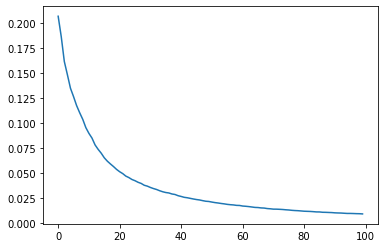

In [15]:
# Entrainement du RBM sur les données d'apprentissage
X = train_data
p = len(X[0])
q = 100
Rbm = init_RBM(p,q)
Rbm,error = train_RBM(Rbm,X,learning_rate, batch_size, output_size)
plt.plot(error)

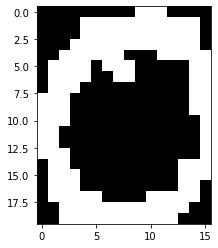

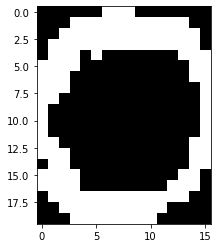

In [16]:
generer_image_RBM(Rbm, nb_iter = 500, nb_images = 2)

Epoch :  0 Erreur :  0.1802761959202557
Epoch :  10 Erreur :  0.0958385251747963
Epoch :  20 Erreur :  0.05223621415088145
Epoch :  30 Erreur :  0.028595053043109334
Epoch :  40 Erreur :  0.016884338684044976
Epoch :  50 Erreur :  0.010444687986504489
Epoch :  60 Erreur :  0.007174438407357211
Epoch :  70 Erreur :  0.005452000381980417
Epoch :  80 Erreur :  0.003936186397045435
Epoch :  90 Erreur :  0.00315947366304519
Epoch :  0 Erreur :  0.16559405474741243
Epoch :  10 Erreur :  0.11760612417971589
Epoch :  20 Erreur :  0.06465131253760766
Epoch :  30 Erreur :  0.03843260224648881
Epoch :  40 Erreur :  0.023997881634923616
Epoch :  50 Erreur :  0.01638402772654897
Epoch :  60 Erreur :  0.010938305325545359
Epoch :  70 Erreur :  0.008144419419273456
Epoch :  80 Erreur :  0.005828067050449651
Epoch :  90 Erreur :  0.004718070866436349
Epoch :  0 Erreur :  0.2620990020668092
Epoch :  10 Erreur :  0.16621069800811616
Epoch :  20 Erreur :  0.08432848252798748
Epoch :  30 Erreur :  0.05645

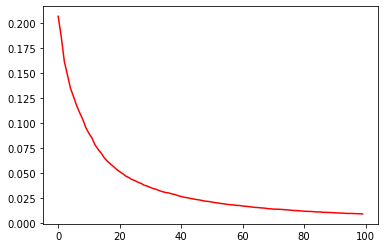

In [17]:
config = [len(X[0]),100,50,100]
X  = lire_alpha_digit(['X'])
Dbm = init_DBN(config)
Dbm = train_DBN(Dbm, X, 0.1, 100, 3)
plt.plot(error, 'red' )

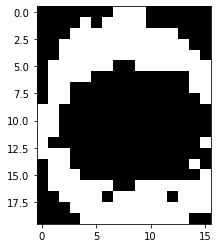

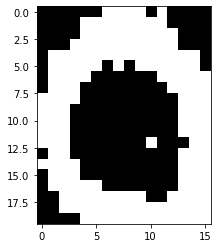

In [18]:
generer_image_RBM(Rbm, 500, 2)